# HW 6
## Joshua Karten


In [151]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from excor import ExchangeCorrelation
from numba import jit

In [152]:
@jit(nopython=True)
def Numerov(f, x0, dx, dh):
    """ Given precumputed function f(x) solved the differential equation
        x''(t) = f(t) x(t)
        input: x0 = x(t=0), and dx = dx/dt(t=0)
    """
    x = np.zeros(len(f))
    x[0] = x0
    x[1] = x0 + dh*dx
    h2 = dh**2
    h12 = h2/12.
    w0 = x0*(1-h12*f[0])
    w1 = x[1]*(1-h12*f[1])
    xi = x[1]
    fi = f[1]
    for i in range(2,len(f)):
        w2 = 2*w1-w0 + h2*fi*xi
        fi = f[i]
        xi = w2/(1-h12*fi)
        x[i]=xi
        (w0,w1) = (w1,w2)
    return x


In [153]:
@jit(nopython=True)
def fShrod(En,l,R, Uks):
    return (l*(l+1.)/R +Uks)/R - En

def ComputeSchrod(En, R, l, Uks):
    #f = fShrod(En,l,R[::-1],Uks[::-1])
    #ur = Numerov(f, 0.0, -1e-10, R[0]-R[1])[::-1]
    f = fShrod(En,l,R, Uks)
    ur = Numerov(f[::-1], 0.0, -1e-10, R[0]-R[1])[::-1]
    norm = sci.integrate.simpson(ur**2, x=R)
    return ur/np.sqrt(abs(norm))

def Shoot(En, R, l, Uks):
    ur = ComputeSchrod(En,R,l, Uks)
    ur = ur/R**l
    poly = np.polyfit(R[:4], ur[:4], deg=3)
    return np.polyval(poly, 0.0)


def Shoot(En, R, l, Uks):
    ur = ComputeSchrod(En, R, l,Uks)
    ur *= 1/R**l  # expecting urn \propto R
    #f0,f1 = ur[0],ur[1]
    #f_at_0 = f0 + (f1-f0)*(0-R[0])/(R[1]-R[0]) # extrapolation to zero
    #return f_at_0
    poly = np.polynomial.Polynomial.fit(R[:4], ur[:4], deg=3)
    return poly(0.0)

def FindBoundStates(R, l, nmax, Esearch, Uks):
    n=0
    Ebnd=[]
    u0 = Shoot(Esearch[0],R,l,Uks)
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l,Uks)
        if u0*u1 < 0:
            Ebound = sci.optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-15,args=(R,l,Uks))
            Ebnd.append( (l,Ebound) )
            if len(Ebnd)>nmax: break
            n += 1
            #print(f"Found bound state at E={Ebound/2:14.9f}H l={l:2d}")
        u0 = u1
    return Ebnd 

@jit(nopython=True)
def rs(rho):
    "1/rho = 4*pi*rs^3/3 => rs = (3/(4*pi*rho))**(1/3.)"
    if rho < 1e-100: return 1e100
    return pow(3/(4*np.pi*rho),1/3.)

def ChargeDensity(bst,R,Zatom,Uks):
    rho = np.zeros(len(R))
    N=0.
    Ebs=0.  # sum of all eigenvalues of KS equation.
    for (l,En) in bst:
        ur = ComputeSchrod(En, R, l, Uks)
        dN = 2*(2*l+1)
        if N+dN <= Zatom:
            ferm = 1.
        else:
            ferm = (Zatom-N)/float(dN)
        drho = ur**2 * ferm * dN/(4*np.pi*R**2)
        rho += drho
        N += dN
        Ebs += En * dN * ferm
        print('adding state', (l,En/2), 'H with fermi=', ferm)
        if  N>=Zatom: break
    return (rho,Ebs)

In [154]:
def FuncForHartree(y,r,rhoSpline):
    """ y = [U,U']
        dy/dr = [U', -8*pi*r*rho(r)]
    """
    return [y[1], -8*np.pi*r*rhoSpline(r)]
def HartreeU(R, rho, Zatom):
    """Given input charge density it returns Hartree potential in the form VH(r)*r
    """
    U2 = NumerovUP(-8*np.pi*R*rho, 0.0, 0.5, R[1]-R[0])
    alpha2 = (2*Zatom-U2[-1])/R[-1]
    U2 += alpha2 * R
    return U2
@jit(nopython=True)
def NumerovUP(U, x0, dx, dh):
    x = np.zeros(len(U))
    x[0] = x0
    x[1] = dx*dh + x0
    h2 = dh*dh
    h12 = h2/12
    w0 = x[0]-h12*U[0]
    w1 = x[1]-h12*U[1]
    Ui = U[1]
    for i in range(2,len(U)):
        w2 = 2*w1 - w0 + h2*Ui
        Ui = U[i]
        xi = w2 + h12*Ui
        x[i] = xi
        w0, w1 = w1, w2
    return x
def cmpKey(x):
    return x[1]*1000 + x[0]  # energy has large wait, but degenerate energy states are sorted by l

(-76.8, 1.0)

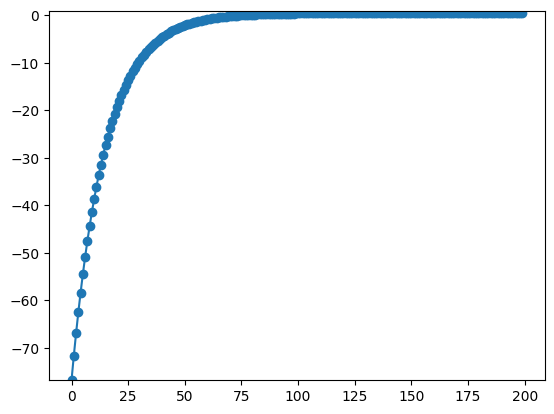

In [155]:
Zatom=8
E0=-1.2*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -np.logspace(-4,np.log10(-E0+Eshift),200)[::-1] + Eshift
fig,ax=plt.subplots()
ax.plot(Esearch,'o-')
plt.ylim([-1.2*Zatom**2,1])

adding state (0, -0.5000000000000028) H with fermi= 1.0
adding state (0, -0.12498711431297789) H with fermi= 1.0
adding state (1, -0.12499460664692987) H with fermi= 0.6666666666666666
Total density has weight 8.0
Itteration 0 Etot[Ry]= -16.726051391754353 Etot[Hartre]= -8.363025695877177 Diff= 16.726051391754353
adding state (0, -29.405159054939325) H with fermi= 1.0
adding state (0, -5.536091363437618) H with fermi= 1.0
adding state (1, -5.4898212692232695) H with fermi= 0.6666666666666666
Total density has weight 7.999999999999999
Itteration 1 Etot[Ry]= -224.73766501605644 Etot[Hartre]= -112.36883250802822 Diff= 208.01161362430207
adding state (0, -22.420013019609364) H with fermi= 1.0
adding state (0, -2.3499680482732077) H with fermi= 1.0
adding state (1, -1.8428684789887049) H with fermi= 0.6666666666666666
Total density has weight 8.0
Itteration 2 Etot[Ry]= -173.90640232350793 Etot[Hartre]= -86.95320116175397 Diff= 50.831262692548506
adding state (0, -19.665018244317377) H with 

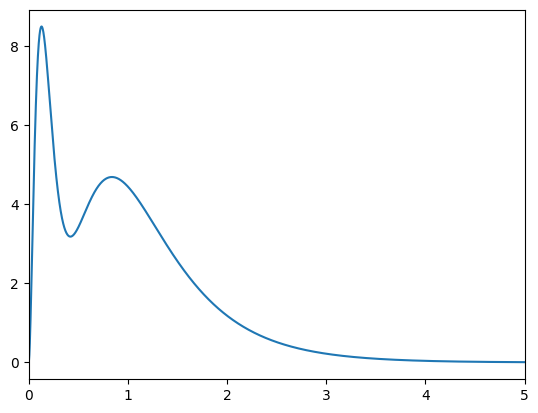

In [156]:
R =np. linspace(1e-8,20,2**14+1)
Zatom = 8 # 20  # 19
mixr = 0.5

E0=-1.2*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -np.logspace(-4,np.log10(-E0+Eshift),200)[::-1] + Eshift
nmax = 4 #3

exc = ExchangeCorrelation()
Uks = -2*np.ones(len(R))
Eold = 0
Etol = 1e-7

for itt in range(1000):
    Bnd=[]
    for l in range(nmax-1):
        Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    
    Bnd = sorted(Bnd, key=cmpKey)
    rho_new, Ebs = ChargeDensity(Bnd,R,Zatom,Uks)
    
    if itt==0:
        rho = rho_new
    else:
        rho = rho_new * mixr + (1-mixr)*rho_old
    rho_old = np.copy(rho)
    
    U2 = HartreeU(R, rho, Zatom)

    Vxc = [2*exc.Vc(rs(rh)) + 2*exc.Vx(rs(rh)) for rh in rho]   
    
    Uks = U2 - 2*Zatom + Vxc*R

    # Total energy
    ExcVxc = [2*exc.EcVc(rs(rh)) + 2*exc.ExVx(rs(rh)) for rh in rho]  # eps_xc(rho)-V_xc(rho)
    pot = (ExcVxc*R - 0.5*U2)*R*rho*4*np.pi                              # (eps_xc-V_xc-0.5 U_H/R)*rho * d^3r
    epot = sci.integrate.simpson(pot, x=R)
    Etot = epot + Ebs
    
    print('Total density has weight', sci.integrate.simpson(rho*(4*np.pi*R**2),x=R))
    #print('Total Energy=', Etot/2.)
    
    print('Itteration', itt, 'Etot[Ry]=', Etot, 'Etot[Hartre]=', Etot/2, 'Diff=', abs(Etot-Eold))

    
    if  itt>0 and abs(Etot-Eold)< Etol: break
    Eold = Etot
    
    #plot(R, U2, label='U-hartree')
    #plot(R, Vxc, label='Vxc')
    #plot(R, Uks, label='Uks')
    #show()
fig,ax = plt.subplots()
ax.plot(R,rho*(4*np.pi*R**2))
plt.xlim([0,5])
plt.show()

Charge density of Oxygen. Computed energy -74.4730769293192 Hartrees.   Agrees with NIST value of -74.473077

C:\Users\milkk\AppData\Local\Temp\ipykernel_772\1063798500.py:10: RuntimeWarning: overflow encountered in square
  norm = sci.integrate.simpson(ur**2, x=R)
c:\Users\milkk\Computational Physics\.venv\Lib\site-packages\scipy\integrate\_quadrature.py:526: RuntimeWarning: overflow encountered in multiply
  y[slice1] * (hsum *
c:\Users\milkk\Computational Physics\.venv\Lib\site-packages\scipy\integrate\_quadrature.py:522: RuntimeWarning: overflow encountered in add
  tmp = hsum/6.0 * (y[slice0] *


adding state (0, -0.5000000000000031) H with fermi= 1.0
adding state (0, -0.1249871143129776) H with fermi= 1.0
adding state (1, -0.12499460664692987) H with fermi= 1.0
adding state (2, -0.05396756442457265) H with fermi= 0.9
Total density has weight 19.0
Itteration 0 Etot[Ry]= -52.36467933246203 Etot[Hartre]= -26.182339666231016 Diff= 52.36467933246203
adding state (0, -40.95663267247373) H with fermi= 1.0
adding state (1, -40.95225964838256) H with fermi= 1.0
adding state (0, -16.003341110540365) H with fermi= 1.0
adding state (1, -15.984773653988436) H with fermi= 1.0
adding state (2, -15.943061091084669) H with fermi= 0.3
Total density has weight 19.0
Itteration 1 Etot[Ry]= -1228.6086854701011 Etot[Hartre]= -614.3043427350506 Diff= 1176.2440061376392
adding state (0, -153.03608518301766) H with fermi= 1.0
adding state (0, -23.692430112167294) H with fermi= 1.0
adding state (1, -22.324636516188402) H with fermi= 1.0
adding state (0, -6.239412485927935) H with fermi= 1.0
adding state

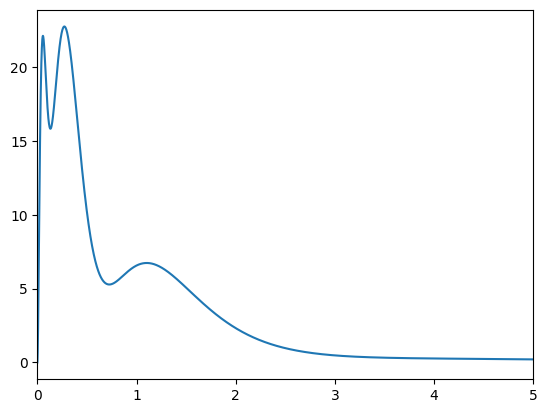

In [157]:
R =np. linspace(1e-8,20,2**14+1)
Zatom = 19 # 20  # 19
mixr = 0.5

E0=-1.2*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -np.logspace(-4,np.log10(-E0+Eshift),200)[::-1] + Eshift
nmax = 4 #3

exc = ExchangeCorrelation()
Uks = -2*np.ones(len(R))
Eold = 0
Etol = 1e-7

for itt in range(1000):
    Bnd=[]
    for l in range(nmax-1):
        Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    
    Bnd = sorted(Bnd, key=cmpKey)
    rho_new, Ebs = ChargeDensity(Bnd,R,Zatom,Uks)
    
    if itt==0:
        rho = rho_new
    else:
        rho = rho_new * mixr + (1-mixr)*rho_old
    rho_old = np.copy(rho)
    
    U2 = HartreeU(R, rho, Zatom)

    Vxc = [2*exc.Vc(rs(rh)) + 2*exc.Vx(rs(rh)) for rh in rho]   
    
    Uks = U2 - 2*Zatom + Vxc*R

    # Total energy
    ExcVxc = [2*exc.EcVc(rs(rh)) + 2*exc.ExVx(rs(rh)) for rh in rho]  # eps_xc(rho)-V_xc(rho)
    pot = (ExcVxc*R - 0.5*U2)*R*rho*4*np.pi                              # (eps_xc-V_xc-0.5 U_H/R)*rho * d^3r
    epot = sci.integrate.simpson(pot, x=R)
    Etot = epot + Ebs
    
    print('Total density has weight', sci.integrate.simpson(rho*(4*np.pi*R**2),x=R))
    #print('Total Energy=', Etot/2.)
    
    print('Itteration', itt, 'Etot[Ry]=', Etot, 'Etot[Hartre]=', Etot/2, 'Diff=', abs(Etot-Eold))

    
    if  itt>0 and abs(Etot-Eold)< Etol: break
    Eold = Etot
    
    #plot(R, U2, label='U-hartree')
    #plot(R, Vxc, label='Vxc')
    #plot(R, Uks, label='Uks')
    #show()
fig,ax = plt.subplots()
ax.plot(R,rho*(4*np.pi*R**2))
plt.xlim([0,5])
plt.show()

In [ ]:
Potassium Charge density. Fills orbitals in order as verified in the bound state output. Energy of -598.2005949492174 Hartrees agrees with NIST value of -598.200590

C:\Users\milkk\AppData\Local\Temp\ipykernel_772\1063798500.py:10: RuntimeWarning: overflow encountered in square
  norm = sci.integrate.simpson(ur**2, x=R)


adding state (0, -0.4999999999999949) H with fermi= 1.0
adding state (0, -0.12498711431297747) H with fermi= 1.0
adding state (1, -0.12499460664692974) H with fermi= 1.0
adding state (2, -0.053967564424572796) H with fermi= 1.0
adding state (1, -0.05161141976121426) H with fermi= 0.16666666666666666
Total density has weight 21.0
Itteration 0 Etot[Ry]= -60.515044216738126 Etot[Hartre]= -30.257522108369063 Diff= 60.515044216738126
adding state (0, -50.70346254715583) H with fermi= 1.0
adding state (1, -50.70140857941912) H with fermi= 1.0
adding state (0, -20.172800880068593) H with fermi= 1.0
adding state (1, -20.15703956905469) H with fermi= 1.0
adding state (2, -20.121669239102236) H with fermi= 0.5
Total density has weight 21.0
Itteration 1 Etot[Ry]= -1620.6499675451503 Etot[Hartre]= -810.3249837725751 Diff= 1560.1349233284122
adding state (0, -29.438175717057366) H with fermi= 1.0
adding state (1, -27.84938196783036) H with fermi= 1.0
adding state (0, -7.907101670980189) H with ferm

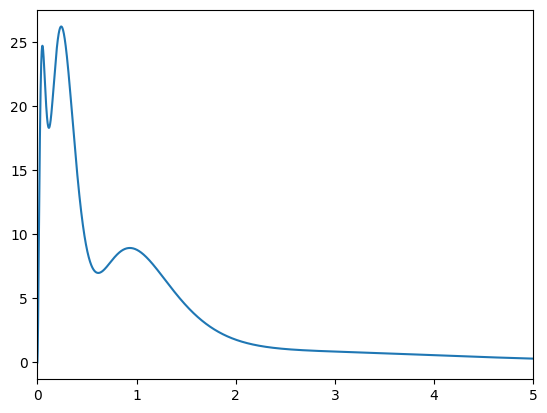

In [158]:
R =np.linspace(1e-8,20,2**14+1)
Zatom = 21 # 20  # 19
mixr = 0.5

E0=-1.2*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -np.logspace(-4,np.log10(-E0+Eshift),200)[::-1] + Eshift
nmax = 4 #3

exc = ExchangeCorrelation()
Uks = -2*np.ones(len(R))
Eold = 0
Etol = 1e-7

for itt in range(1000):
    Bnd=[]
    for l in range(nmax-1):
        Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    
    Bnd = sorted(Bnd, key=cmpKey)
    rho_new, Ebs = ChargeDensity(Bnd,R,Zatom,Uks)
    
    if itt==0:
        rho = rho_new
    else:
        rho = rho_new * mixr + (1-mixr)*rho_old
    rho_old = np.copy(rho)
    
    U2 = HartreeU(R, rho, Zatom)

    Vxc = [2*exc.Vc(rs(rh)) + 2*exc.Vx(rs(rh)) for rh in rho]   
    
    Uks = U2 - 2*Zatom + Vxc*R

    # Total energy
    ExcVxc = [2*exc.EcVc(rs(rh)) + 2*exc.ExVx(rs(rh)) for rh in rho]  # eps_xc(rho)-V_xc(rho)
    pot = (ExcVxc*R - 0.5*U2)*R*rho*4*np.pi                              # (eps_xc-V_xc-0.5 U_H/R)*rho * d^3r
    epot = sci.integrate.simpson(pot, x=R)
    Etot = epot + Ebs
    
    print('Total density has weight', sci.integrate.simpson(rho*(4*np.pi*R**2),x=R))
    #print('Total Energy=', Etot/2.)
    
    print('Itteration', itt, 'Etot[Ry]=', Etot, 'Etot[Hartre]=', Etot/2, 'Diff=', abs(Etot-Eold))

    
    if  itt>0 and abs(Etot-Eold)< Etol: break
    Eold = Etot
    
    #plot(R, U2, label='U-hartree')
    #plot(R, Vxc, label='Vxc')
    #plot(R, Uks, label='Uks')
    #show()
fig,ax = plt.subplots()
ax.plot(R,rho*(4*np.pi*R**2))
plt.xlim([0,5])
plt.show()

Charge density of Scandium. Fills up the states in order and agrees with the NIST energy of -758.679275

In [ ]:
C

C:\Users\milkk\AppData\Local\Temp\ipykernel_772\1063798500.py:10: RuntimeWarning: overflow encountered in square
  norm = sci.integrate.simpson(ur**2, x=R)


adding state (0, -0.5000000000021018) H with fermi= 1.0
adding state (0, -0.12498711430561779) H with fermi= 1.0
adding state (1, -0.12499460664786712) H with fermi= 1.0
adding state (2, -0.05396756441937444) H with fermi= 1.0
adding state (1, -0.05161141976090261) H with fermi= 0.3333333333333333
Itteration 0 Etot[Ry]= -64.73044586034015 Etot[Hartre]= -32.36522293017008 Diff= 64.73044586034015
adding state (0, -55.94712232392749) H with fermi= 1.0
adding state (1, -55.945990073472935) H with fermi= 1.0
adding state (0, -22.421176496129686) H with fermi= 1.0
adding state (1, -22.406618094452604) H with fermi= 1.0
adding state (2, -22.373969662233215) H with fermi= 0.6
Itteration 1 Etot[Ry]= -1844.0021732114394 Etot[Hartre]= -922.0010866057197 Diff= 1779.2717273510993
adding state (0, -32.5325013040968) H with fermi= 1.0
adding state (1, -30.82824332906767) H with fermi= 1.0
adding state (0, -8.806782307933174) H with fermi= 1.0
adding state (1, -8.036901973067652) H with fermi= 1.0
add

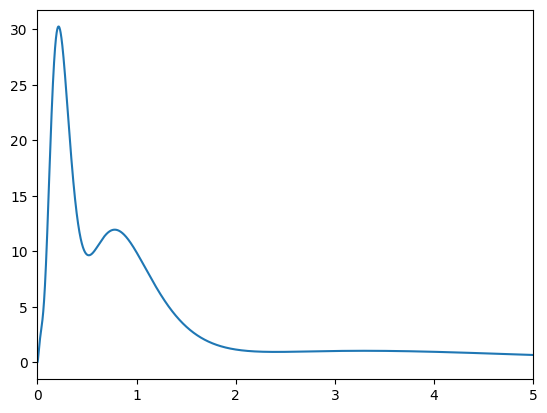

In [163]:
R =np. linspace(1e-9,20,2**17+1)
Zatom = 22 # 20  # 19
mixr = 0.5

E0=-1.5*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -np.logspace(-4,np.log10(-E0+Eshift),5000)[::-1] + Eshift
nmax = 4#3

exc = ExchangeCorrelation()
Uks = -2*np.ones(len(R))
Eold = 0
Etol = 1e-7

for itt in range(20):
    Bnd=[]
    for l in range(nmax-1):
        Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    
    Bnd = sorted(Bnd, key=cmpKey)
    rho_new, Ebs = ChargeDensity(Bnd,R,Zatom,Uks)
    
    if itt==0:
        rho = rho_new
    else:
        rho = rho_new * mixr + (1-mixr)*rho_old
    rho_old = np.copy(rho)
    
    U2 = HartreeU(R, rho, Zatom)

    Vxc = [2*exc.Vc(rs(rh)) + 2*exc.Vx(rs(rh)) for rh in rho]   
    
    Uks = U2 - 2*Zatom + Vxc*R

    # Total energy
    ExcVxc = [2*exc.EcVc(rs(rh)) + 2*exc.ExVx(rs(rh)) for rh in rho]  # eps_xc(rho)-V_xc(rho)
    pot = (ExcVxc*R - 0.5*U2)*R*rho*4*np.pi                              # (eps_xc-V_xc-0.5 U_H/R)*rho * d^3r
    epot = sci.integrate.simpson(pot, x=R)
    Etot = epot + Ebs
    
  #  print('Total density has weight', sci.integrate.simpson(rho*(4*np.pi*R**2),x=R))
    #print('Total Energy=', Etot/2.)
    
    print('Itteration', itt, 'Etot[Ry]=', Etot, 'Etot[Hartre]=', Etot/2, 'Diff=', abs(Etot-Eold))

    
    if  itt>0 and abs(Etot-Eold)< Etol: break
    Eold = Etot
    
    #plot(R, U2, label='U-hartree')
    #plot(R, Vxc, label='Vxc')
    #plot(R, Uks, label='Uks')
    #show()
fig,ax = plt.subplots()
ax.plot(R,rho*(4*np.pi*R**2))
plt.xlim([0,5])
plt.show()

Nothing yet has improved the algorithm to make it work for z=22. I have tried increasing the starting energy, energy range, etc but it has not yielded proper results. What I do notice is that it is getting very confused about which orbitals to fill. It is consistently missing the first s orbital, sometimes skipping the last s orbital when it finds the d orbital, and alternating between filling 4p and 3d.